In [49]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import re

In [63]:
from tensorflow import keras
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline
from keras.models import Model
from keras.optimizers.legacy import RMSprop
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Add, BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical

In [2]:
def show_image(image, title = 'Image', cmap_type = 'gray'):
    plt.imshow(image, cmap = cmap_type)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
def load_process_images(image_folder, crop = True, do_resize = True, resize_prop = 0.2):
    # Initialize an empty dictionary to store filename-image pairs
    image_dict = {}

    # List all files in the folder
    file_list = [file for file in os.listdir(image_folder) if file.endswith('.png')]

    # Loop through each file and read the image
    for file_name in file_list:
        # Construct the full path to the image file
        file_path = os.path.join(image_folder, file_name)
    
        # Read the image using plt.imread and store it in the dictionary
        image_array = plt.imread(file_path)

        # Crop the image
        if crop:
            image_array = image_array[82:562, 211:911]
    
        # Convert the image to grayscale
        image_array = rgb2gray(image_array)

        # Resize the image
        if do_resize:
            height, width = (image_array.shape[0] * resize_prop, image_array.shape[1] * resize_prop)

            image_array = resize(image_array, (height, width), anti_aliasing = True)

        # Add the image to the dictionary
        image_dict[file_name[:-4]] = image_array

    return image_dict

In [7]:
yenchen_images = load_process_images('./yenchen_frames')
sam_images = load_process_images('./sam_frames')

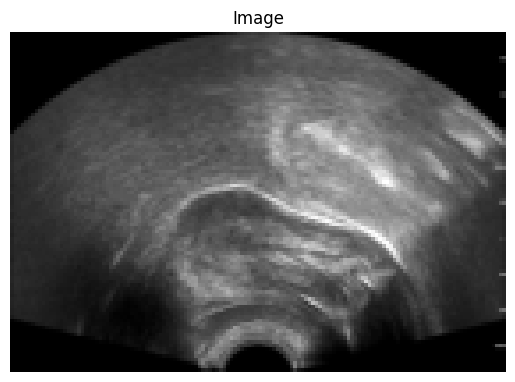

In [10]:
show_image(yenchen_images['a1'])

In [38]:
# Transform the dictionary of images to a 3d array
def dict_to_arrays(image_dict):
    # Extract image arrays and labels
    labels = [re.sub(r'\d', '', label) for label in list(image_dict.keys())]
    image_lst = list(image_dict.values())

    # Convert the list of image arrays into a NumPy array
    label_array = np.array(labels)
    image_arrays = np.array(image_lst)

    return image_arrays, label_array
    
    

In [39]:
yenchen_arrays, yenchen_labels = dict_to_arrays(yenchen_images)
sam_arrays, sam_labels = dict_to_arrays(sam_images)

In [41]:
print(yenchen_arrays.shape)
print(yenchen_labels.shape)

(600, 96, 140)
(600,)


In [67]:
yenchen_labels[:10]

array(['u', 'o', 'a', 'a', 'a', 'i', 'i', 'schwa', 'schwa', 'schwa'],
      dtype='<U5')

In [44]:
# Split the data into training and testing sets
yenchen_train, yenchen_test, yenchen_train_labels, yenchen_test_labels = train_test_split(
    yenchen_arrays,
    yenchen_labels,
    test_size = 0.2,
    random_state = 17,
    stratify = yenchen_labels  # Ensure consistent shuffling of both data and labels
)

sam_train, sam_test, sam_train_labels, sam_test_labels = train_test_split(
    sam_arrays,
    sam_labels,
    test_size = 0.2,
    random_state = 17,
    stratify = sam_labels
)

In [50]:
# Combine the training and testing sets
combined_train = np.concatenate((yenchen_train, sam_train), axis = 0)
combined_test = np.concatenate((yenchen_test, sam_test), axis = 0)
combined_train_labels = np.concatenate((yenchen_train_labels, sam_train_labels), axis = 0)
combined_test_labels = np.concatenate((yenchen_test_labels, sam_test_labels), axis = 0)

# Shuffle the combined data
combined_train, combined_train_labels = shuffle(combined_train, combined_train_labels, random_state = 17)
combined_test, combined_test_labels = shuffle(combined_test, combined_test_labels, random_state = 17)

In [53]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape = combined_train.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape = combined_test.shape))


Training set (images) shape: (960, 96, 140)
Test set (images) shape: (240, 96, 140)


In [55]:
# Convert each 96 x 140 image of train and test set into a matrix of 96 x 140 x 1
train_data = combined_train.reshape(-1, 96, 140, 1)
test_data = combined_test.reshape(-1, 96, 140, 1)
train_data.shape, test_data.shape

((960, 96, 140, 1), (240, 96, 140, 1))

In [57]:
# Verify the train and test datatype
train_data.dtype, test_data.dtype

(dtype('float32'), dtype('float32'))

In [58]:
np.max(train_data), np.max(test_data)

(0.99798506, 0.99722964)

In [71]:
train_X, valid_X, train_ground, valid_ground = train_test_split(train_data,
                                                                train_data,
                                                                test_size = 0.2,
                                                                random_state = 13)

In [72]:
batch_size = 64 # number of training examples used in one iteration
epochs = 200 # number of passes through entire dataset
inChannel = 1 # grayscale
x, y = 96, 140 # image dimensions
input_img = Input(shape = (x, y, inChannel)) # input image
num_classes = 6 # number of classes: 6 vowels (a, e, u, e, o, schwa)

In [73]:
def encoder(input_img):
    #encoder
    # input = 96 x 140 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img) #96 x 140 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1) #48 x 70 x 32
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1) #48 x 70 x 64 (small and thick)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #24 x 35 x 64
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2) #24 x 35 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv3) #24 x 35 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv4) #24 x 35 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv5) #24 x 35 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) # 48 x 70 x 64
    conv7 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(up1) # 48 x 70 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 96 x 140 x 32
    decoded = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(up2) # 96 x 140 x 1
    return decoded


In [74]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())


In [75]:
autoencoder.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 140, 1)]      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 96, 140, 32)       320       
                                                                 
 batch_normalization_28 (Ba  (None, 96, 140, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 96, 140, 32)       9248      
                                                                 
 batch_normalization_29 (Ba  (None, 96, 140, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 48, 70, 32)        0   

In [76]:
# Train the model
autoencoder_train = autoencoder.fit(train_X, train_ground, 
                                    batch_size = batch_size, 
                                    epochs = epochs, 
                                    verbose = 1, 
                                    validation_data = (valid_X, valid_ground))


Epoch 1/200
12/12 [==============================] - 41s 3s/step - loss: 0.0974 - val_loss: 0.0636
Epoch 2/200
12/12 [==============================] - 43s 4s/step - loss: 0.0350 - val_loss: 0.0463
Epoch 3/200
12/12 [==============================] - 46s 4s/step - loss: 0.0239 - val_loss: 0.0362
Epoch 4/200
12/12 [==============================] - 48s 4s/step - loss: 0.0166 - val_loss: 0.0319
Epoch 5/200
12/12 [==============================] - 47s 4s/step - loss: 0.0124 - val_loss: 0.0329
Epoch 6/200
12/12 [==============================] - 48s 4s/step - loss: 0.0109 - val_loss: 0.0337
Epoch 7/200
12/12 [==============================] - 48s 4s/step - loss: 0.0080 - val_loss: 0.0410
Epoch 8/200
12/12 [==============================] - 49s 4s/step - loss: 0.0072 - val_loss: 0.0416
Epoch 9/200
12/12 [==============================] - 51s 4s/step - loss: 0.0057 - val_loss: 0.0432
Epoch 10/200
12/12 [==============================] - 50s 4s/step - loss: 0.0056 - val_loss: 0.0397
Epoch 11/

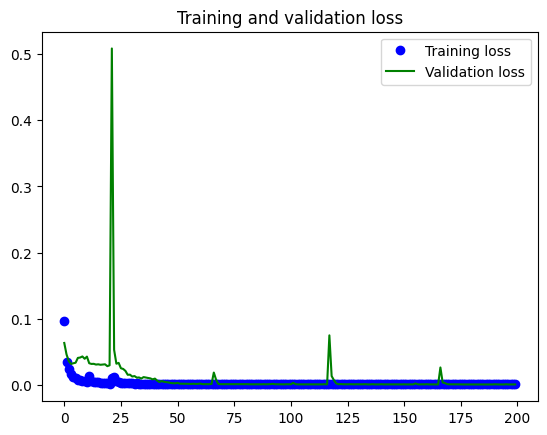

In [77]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [78]:
# Save the weights of the model
autoencoder.save_weights('autoencoder.h5')

In [81]:
# Create dictionary of target classes
label2int = {
    'a': 0,
    'e': 1,
    'i': 2,
    'o': 3,
    'u': 4,
    'schwa': 5
}

In [83]:
# Transform combined_train_labels and combined_test_labels to integers using label_dict
combined_train_labels = [label2int[label] for label in combined_train_labels]
combined_test_labels = [label2int[label] for label in combined_test_labels]

In [85]:
# Turn combined_train_labels and combined_test_labels into one-hot encoded vectors
train_labels_one_hot = to_categorical(combined_train_labels)
test_labels_one_hot = to_categorical(combined_test_labels)

In [87]:
# Display the change for category label using one-hot encoding
print('Original label:', combined_train_labels[0])
print('After conversion to one-hot:', train_labels_one_hot[0])

Original label: 0
After conversion to one-hot: [1. 0. 0. 0. 0. 0.]


In [88]:
train_X, valid_X, train_label, valid_label = train_test_split(train_data,
                                                                train_labels_one_hot,
                                                                test_size = 0.2,
                                                                random_state = 13)

In [89]:
# Check the shape of training and validation set
train_X.shape, valid_X.shape, train_label.shape, valid_label.shape

((768, 96, 140, 1), (192, 96, 140, 1), (768, 6), (192, 6))

In [90]:
def encoder(input_img):
    #encoder
    # input = 96 x 140 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(input_img) #96 x 140 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation = 'relu', padding = 'same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size = (2, 2))(conv1) #48 x 70 x 32
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(pool1) #48 x 70 x 64 (small and thick)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #24 x 35 x 64
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(pool2) #24 x 35 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv3) #24 x 35 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

In [91]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation = 'relu')(flat)
    out = Dense(num_classes, activation = 'softmax')(den)
    return out

In [92]:
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [93]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [94]:
autoencoder.get_weights()[0][1]

array([[[-0.01106074,  0.06560605, -0.0018325 , -0.12678844,
          0.09085999,  0.08507562,  0.02368462,  0.04575466,
         -0.0621221 , -0.0051522 ,  0.10771452,  0.06263155,
          0.14920957, -0.00788951, -0.05855837, -0.04341372,
         -0.12344737, -0.02435557,  0.02859077,  0.09293944,
          0.13004032,  0.01643268,  0.12114952, -0.14762707,
         -0.05801519, -0.05004796, -0.07643075,  0.14320303,
         -0.07584979, -0.0524631 ,  0.03206529, -0.11175833]],

       [[ 0.11058889,  0.10289725, -0.01867787,  0.01763318,
          0.11039515, -0.03368187, -0.10162255,  0.0879199 ,
          0.05373702,  0.05876   ,  0.01097057,  0.03432561,
         -0.04584125, -0.11058342,  0.03637708, -0.05810952,
         -0.05317052,  0.05554533,  0.05870493, -0.11295915,
         -0.07036964,  0.02119622, -0.05426754, -0.14702505,
         -0.04232376,  0.08717795, -0.05617746,  0.06632923,
         -0.02406691,  0.04345812, -0.00734879, -0.11788792]],

       [[ 0.026764

In [95]:
full_model.get_weights()[0][1]

array([[[-0.01106074,  0.06560605, -0.0018325 , -0.12678844,
          0.09085999,  0.08507562,  0.02368462,  0.04575466,
         -0.0621221 , -0.0051522 ,  0.10771452,  0.06263155,
          0.14920957, -0.00788951, -0.05855837, -0.04341372,
         -0.12344737, -0.02435557,  0.02859077,  0.09293944,
          0.13004032,  0.01643268,  0.12114952, -0.14762707,
         -0.05801519, -0.05004796, -0.07643075,  0.14320303,
         -0.07584979, -0.0524631 ,  0.03206529, -0.11175833]],

       [[ 0.11058889,  0.10289725, -0.01867787,  0.01763318,
          0.11039515, -0.03368187, -0.10162255,  0.0879199 ,
          0.05373702,  0.05876   ,  0.01097057,  0.03432561,
         -0.04584125, -0.11058342,  0.03637708, -0.05810952,
         -0.05317052,  0.05554533,  0.05870493, -0.11295915,
         -0.07036964,  0.02119622, -0.05426754, -0.14702505,
         -0.04232376,  0.08717795, -0.05617746,  0.06632923,
         -0.02406691,  0.04345812, -0.00734879, -0.11788792]],

       [[ 0.026764

In [96]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [97]:
full_model.compile(loss = keras.losses.categorical_crossentropy, 
                   optimizer = keras.optimizers.Adam(), 
                   metrics = ['accuracy'])

In [98]:
full_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 140, 1)]      0         
                                                                 
 conv2d_45 (Conv2D)          (None, 96, 140, 32)       320       
                                                                 
 batch_normalization_42 (Ba  (None, 96, 140, 32)       128       
 tchNormalization)                                               
                                                                 
 conv2d_46 (Conv2D)          (None, 96, 140, 32)       9248      
                                                                 
 batch_normalization_43 (Ba  (None, 96, 140, 32)       128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 48, 70, 32)        0   

In [99]:
classify_train = full_model.fit(train_X, train_label, 
                                batch_size = 64,
                                epochs = 100,
                                verbose = 1,
                                validation_data = (valid_X, valid_label))

Epoch 1/100
12/12 [==============================] - 10s 844ms/step - loss: 79.9174 - accuracy: 0.4219 - val_loss: 6.7456 - val_accuracy: 0.7448
Epoch 2/100
12/12 [==============================] - 9s 780ms/step - loss: 2.9740 - accuracy: 0.9089 - val_loss: 0.2877 - val_accuracy: 0.9896
Epoch 3/100
12/12 [==============================] - 10s 823ms/step - loss: 0.6022 - accuracy: 0.9766 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/100
12/12 [==============================] - 10s 872ms/step - loss: 0.0608 - accuracy: 0.9935 - val_loss: 6.2088e-10 - val_accuracy: 1.0000
Epoch 5/100
12/12 [==============================] - 11s 911ms/step - loss: 0.0705 - accuracy: 0.9948 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/100
12/12 [==============================] - 11s 907ms/step - loss: 2.3732e-07 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/100
12/12 [==============================] - 12s 1s/step - loss: 1.6191e-04 - accuracy: 1.0000 - val_loss: 0

In [100]:
full_model.save_weights('classification_complete.h5')

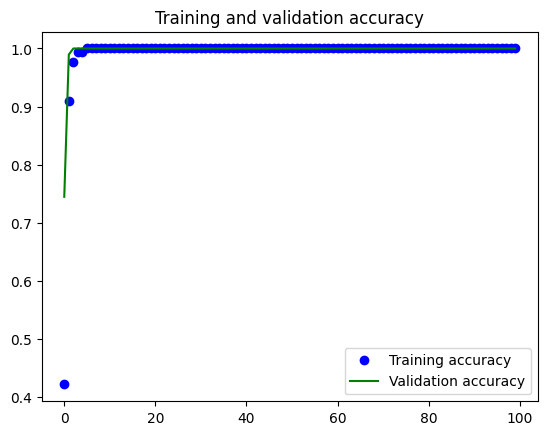

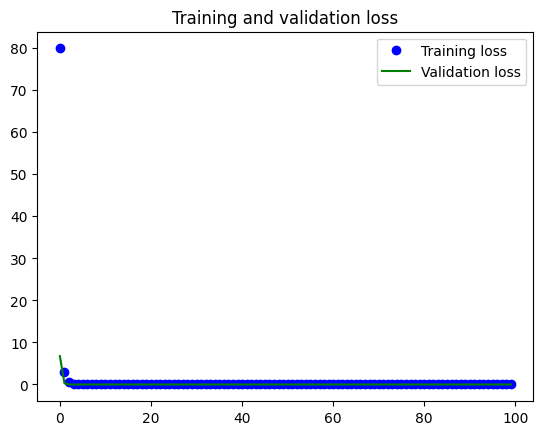

In [104]:
accuracy = classify_train.history['accuracy']
val_accuracy = classify_train.history['val_accuracy']
loss = classify_train.history['loss']
val_loss = classify_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'g', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [105]:
# Evaluate the model on test set
test_eval = full_model.evaluate(test_data, test_labels_one_hot, verbose = 0)

In [106]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.09463883936405182
Test accuracy: 0.9916666746139526


In [107]:
# Predict the labels of the test set
predicted_classes = full_model.predict(test_data)

8/8 [==============================] - 2s 273ms/step


In [108]:
predicted_classes = np.argmax(np.round(predicted_classes),axis = 1)

In [110]:
predicted_classes.shape, np.array(combined_test_labels).shape

((240,), (240,))

In [124]:
int2label = {
    0: 'a',
    1: 'e',
    2: 'i',
    3: 'o',
    4: 'u',
    5: 'ə'
}

Found 238 correct labels


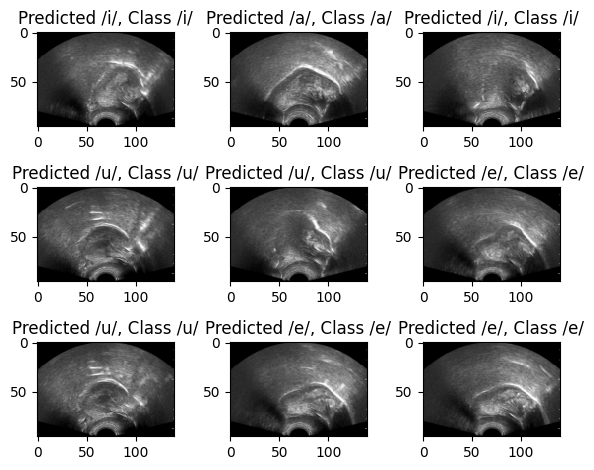

In [125]:
correct = np.where(predicted_classes == np.array(combined_test_labels))[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_data[correct].reshape(96, 140), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted /{}/, Class /{}/".format(int2label[predicted_classes[correct]], int2label[np.array(combined_test_labels)[correct]]))
    plt.tight_layout()

Found 2 incorrect labels


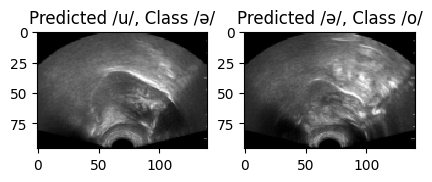

In [126]:
incorrect = np.where(predicted_classes != np.array(combined_test_labels))[0]
print("Found %d incorrect labels" % len(incorrect))
for i, incorrect in enumerate(incorrect[:9]):
    plt.subplot(3, 3, i + 1)
    plt.imshow(test_data[incorrect].reshape(96, 140), cmap = 'gray', interpolation = 'none')
    plt.title("Predicted /{}/, Class /{}/".format(int2label[predicted_classes[incorrect]], int2label[np.array(combined_test_labels)[incorrect]]))
    plt.tight_layout()